In [66]:
import numpy as np
import matplotlib.pyplot as plt

# 基础变量设置
dx = 0.1  # 空间步长，单位：米
dt = 0.004    # 时间步长，单位：秒
lambda_ = dt / dx  
x_points = 11   #(0,10)   
t_points = 3000  


# 初始化u数组
u1 = np.zeros((x_points, t_points + 1))
u2 = np.zeros((x_points, t_points + 1))

A = 1.5
# 初始条件1: u(x,0) = sin(2πx)
u1[:, 0] = np.sin(2 * np.pi * np.arange(0, 1.1, dx))
# 初始条件2: u(x,0) = A + sin(2πx)
u2[:, 0] = A + np.sin(2 * np.pi * np.arange(0, 1.1, dx))

print(u1[:,0])


[ 0.00000000e+00  5.87785252e-01  9.51056516e-01  9.51056516e-01
  5.87785252e-01  1.22464680e-16 -5.87785252e-01 -9.51056516e-01
 -9.51056516e-01 -5.87785252e-01 -2.44929360e-16]


In [68]:

def solve_1(u): 
    #输入带有初始条件的u数组和基础条件，输出求解完成后的总动能K(n)，改写为通量方法求解
    K = np.zeros(t_points + 1)
    #lambda_ = dt / dx
    
    # 初始化边界条件
    #u[0, 0] = 0.0
    #u[-1, 0] = 0.0
    
    K[0] = 0.5 * np.sum(u[:, 0]**2)

    # 前差起步格式，使用模运算处理周期边界
    for m in range(x_points):
        m_plus = (m + 1) % x_points
        m_minus = (m - 1) % x_points
        u[m, 1] = u[m, 0] - (lambda_ / 8) * (
            (u[m_plus, 0] + u[m, 0])**2 - 
            (u[m, 0] + u[m_minus, 0])**2
        )

    # 边界点保持为0
    #u[0, 1] = 0.0
    #u[-1, 1] = 0.0
    
    K[1] = 0.5 * np.sum(u[:, 1]**2)

    # 三层差分格式，使用模运算处理周期边界
    for n in range(1, t_points):
        for m in range(x_points):
            m_plus = (m + 1) % x_points
            m_minus = (m - 1) % x_points
            u[m, n + 1] = u[m, n - 1] - (lambda_ / 4) * (
                (u[m_plus, n] + u[m, n])**2 - 
                (u[m, n] + u[m_minus, n])**2
            )

        # 边界点保持为0
        #u[0, n + 1] = 0.0
        #u[-1, n + 1] = 0.0
        
        K[n + 1] = 0.5 * np.sum(u[:, n + 1]**2)

    return K

#K1 = solve_1(u1)
#print(K1)
#K2 = solve_1(u2)
#print(K2)

# 绘制K(n)随n的变化曲线
#plt.figure(figsize=(10, 6))
#plt.plot(K1, label='Initial Condition 1')
#plt.plot(K2, label='Initial Condition 2')
#plt.xlabel('Time Step')
#plt.ylabel('Average Kinetic Energy')
#plt.title('Average Kinetic Energy vs Time Step')
#plt.legend()
#plt.grid()
#plt.show()

In [69]:
# 通量和平流组合格式（迭代法） 
def solve_2(u):     
    #输入带有初始条件的u数组，输出求解完成后的总动能K(n)，改写为通量和平流组合，用迭代法求解
    K = np.zeros(t_points + 1)
    #lambda_ = dt / dx  
    tolerance = 1e-5  # 迭代收敛条件
    
    # 初始化刚性边界条件
    #u[0, 0] = 0.0
    #u[-1, 0] = 0.0
    
    K[0] = 0.5 * np.sum(u[:, 0]**2)

    # 前差格式计算第一个时间步，使用模运算处理周期边界
    for m in range(x_points):
        m_plus = (m + 1) % x_points
        m_minus = (m - 1) % x_points
        u[m, 1] = u[m, 0] - (lambda_ / 8) * (
            (u[m_plus, 0] + u[m, 0])**2 - 
            (u[m, 0] + u[m_minus, 0])**2
        )

    # 边界点保持为0
    #u[0, 1] = 0.0
    #u[-1, 1] = 0.0
    
    K[1] = 0.5 * np.sum(u[:, 1]**2)

    # 迭代法求解剩余时间步
    for n in range(1, t_points):
        # 初始化迭代变量
        u_prev_iter = np.copy(u[:, n])  # 初始迭代猜测为当前时间步的值
        flag = False
        while not flag:
            u_new = np.copy(u[:, n])  # 初始化新时间步的值
            # 计算中间变量 u_bar
            u_bar = 0.5 * (u[:, n] + u_prev_iter)

            # 更新所有网格点（使用模运算处理周期边界）
            for m in range(x_points):
                m_plus = (m + 1) % x_points
                m_minus = (m - 1) % x_points
                term = (u_bar[m_plus] + u_bar[m] + u_bar[m_minus]) * (u_bar[m_plus] - u_bar[m_minus])
                u_new[m] = u[m, n] - (lambda_ / 6) * term

            # 检查收敛条件
            max_diff = np.max(np.abs(u_new - u_prev_iter))
            if max_diff < tolerance:
                flag = True
            else:
                u_prev_iter = np.copy(u_new)  # 更新迭代猜测

            
        
        # 将收敛后的值存入下一个时间步
        u[:, n + 1] = u_new

        # 边界点保持为0
        #u[0, n + 1] = 0.0
        #u[-1, n + 1] = 0.0
        
        K[n + 1] = 0.5 * np.sum(u[:, n + 1]**2)
    return K

#K2 = solve_2(u2)
#print(K2)

# 绘制K(n)随n的变化曲线
#plt.figure(figsize=(10, 6))
#plt.plot(K2, label='Initial Condition 1')
#plt.xlabel('Time Step')
#plt.ylabel('Average Kinetic Energy')
#plt.title('Average Kinetic Energy vs Time Step')
#plt.legend()
#plt.grid()
#plt.show()
    

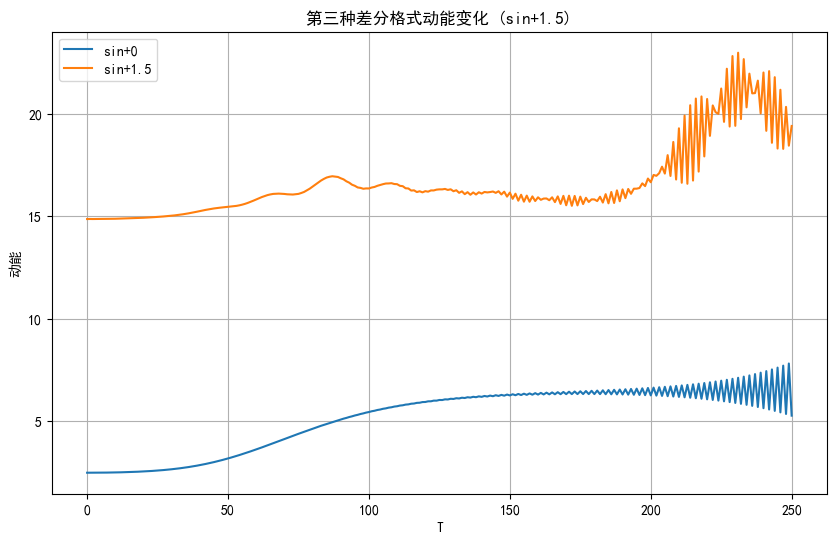

In [65]:
#第三种差分格式（不做变换直接差分）
def solve_3(u): 
    #输入带有初始条件的u数组和基础条件，输出求解完成后的总动能K(n),直接差分
    K = np.zeros(t_points + 1)
    #lambda_ = dt / dx

    # 初始化边界条件
    #u[0, 0] = 0.0
    #u[-1, 0] = 0.0
    
    K[0] = 0.5 * np.sum(u[:, 0]**2)

    # 前差起步格式，使用模运算处理周期边界
    for m in range(x_points):
        m_plus = (m + 1) % x_points
        m_minus = (m - 1) % x_points
        u[m, 1] = u[m, 0] - (lambda_ / 2) * (u[m, 0])* (u[m_plus, 0] - u[m_minus, 0])

    # 边界点保持为0
    #u[0, 1] = 0.0
    #u[-1, 1] = 0.0
    
    K[1] = 0.5 * np.sum(u[:, 1]**2)

    # 三层差分格式，使用模运算处理周期边界
    for n in range(1, t_points):
        for m in range(x_points):
            m_plus = (m + 1) % x_points
            m_minus = (m - 1) % x_points
            u[m, n + 1] = u[m, n - 1] - (lambda_ *u[m, n])*(u[m_plus, n] - u[m_minus, n])

        # 边界点保持为0
        #u[0, n + 1] = 0.0
        #u[-1, n + 1] = 0.0
        
        K[n + 1] = 0.5 * np.sum(u[:, n + 1]**2)

    return K

K3 = solve_3(u1)
K4 = solve_3(u2)

# 绘制K(n)随n的变化曲线
plt.figure(figsize=(10, 6))
plt.plot(K3, label='sin+0')
plt.plot(K4, label=f'sin+{A}')

plt.xlabel('T')
plt.ylabel('动能')
plt.title(f'第三种差分格式动能变化 (sin+{A})')
plt.legend()
plt.grid()
plt.show()

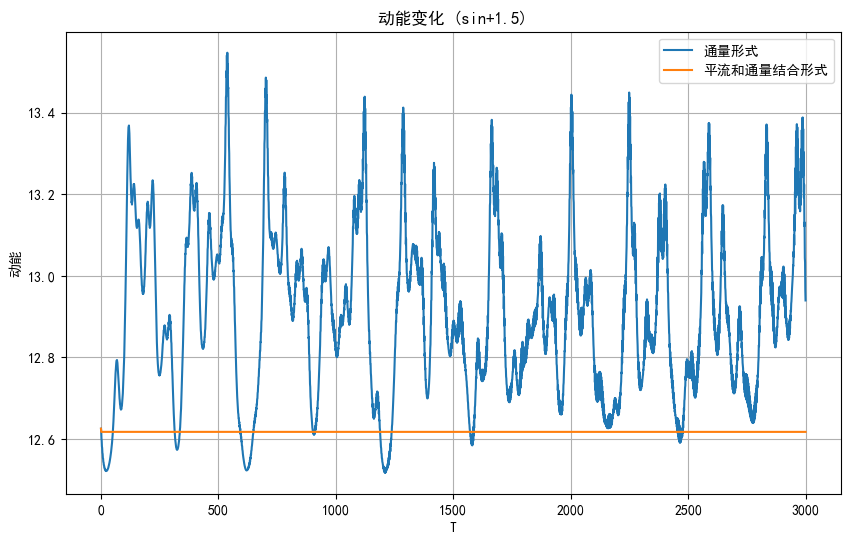

In [70]:
K1 = solve_1(u2)
#print(K1)
K2 = solve_2(u2)
#print(K2)

# 显示中文
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 绘制K(n)随n的变化曲线
plt.figure(figsize=(10, 6))
plt.plot(K1, label='通量形式')
plt.plot(K2, label='平流和通量结合形式')


plt.xlabel('T')
plt.ylabel('动能')
plt.title(f'动能变化 (sin+{A})')
plt.legend()
plt.grid()
plt.show()